<a href="https://colab.research.google.com/github/codevicky/Goodrich/blob/master/lstm_stock_market_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Predictions with LSTM


## Why Do we Need Time Series Models?

we would like to model this stock prices correctly, so as a stock buyer can reasonably decide when to buy stocks and when to sell them to gain profit. This is where time series modelling comes in. we need good machine learning models that can look at the history of a sequence of data and correctly predict the future elements of the sequence are going to be.

**Warning**: Stock market prices are highly unpredictable and volatile. This means that there are no consistent patterns in the data that allows us to model stock prices over time near-perfectly.

However, let's not go all the way believing that this is just a stochastic / random process and no hope for machine learning. Let's see if we can at least model the data, so that the predictions we make correlate with the actual behavior of the data. In other words, we don't need the exact stock values of the future, but the stock price movements (that is, if it is going to rise of fall in the near future).

In [0]:
# Make sure that all these libaries available to run the code successfully
!pip install pandas_datareader
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [0]:
!ls
df = pd.read_csv('hpq.us.txt',delimiter=',',usecols=['Date','Open','High','Low','Close'])
df = df.sort_values('Date')


batch.png  hpq.us.txt  lstm.png  sample_data


### Data Exploration

Here we will print the data we collected in to the dataframe. we also will make sure that the data is sorted by the date. Because the order of data is crucial in time series modelling. 

In [0]:
df.head()

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


#### Data Visualization
Now let's see what sort of data we have at our hand. we want data with various patterns occurring over time.

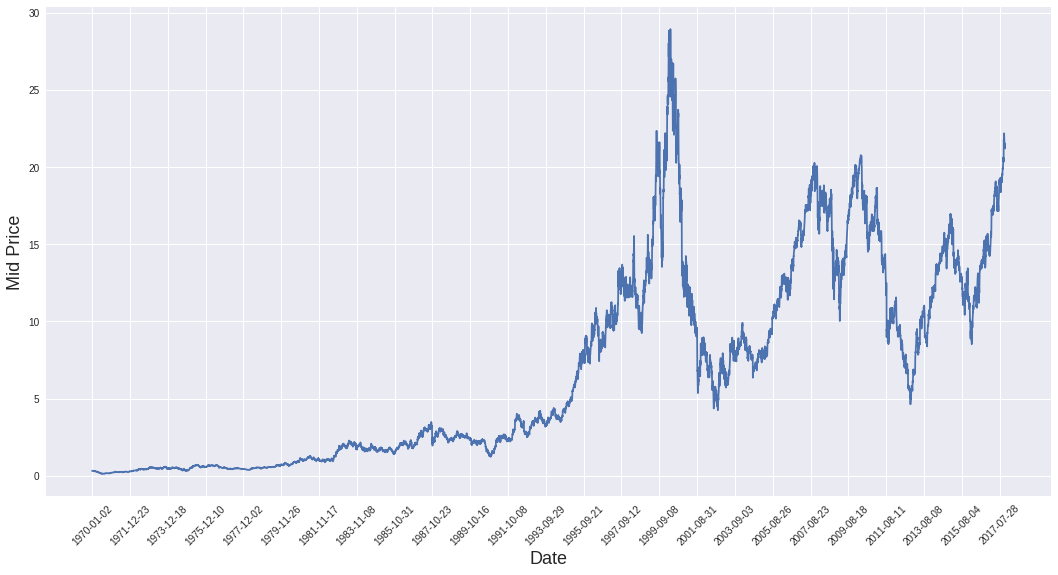

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

This graph already says a lot of things. The Specific reason we picked this company over others is that this graph is bursting with different behaviors of stock prices over time. This will make the learning more robust as well as give us a chance to test how good the predictions are for a variety of situations. 

Another thing to notice is that the values close to 2017 are much higher and highly fluctuating than the values close to 1970s. Therefore we need to make sure that the data behaves in similar value ranges throughout the time frame. we will take care of this during the *data normalization*.


## Breaking Data to Train and Test and Normalizing Data

we will use the mid price calculated by taking the average of the highest and lowest recorded prices on a day

In [0]:
# First calculate the mid prices from the highest and lowest 
high_prices = df.loc[:,'High'].as_matrix()
low_prices = df.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

Now we can break the train data and test data. Train data will be the first 11000 data points of the time series and rest will be test data.

In [0]:
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

Now we need to define a scaler to normalize data `MinMaxScalar` scales all the data to be in the region of 0 and 1. we also reshape the train and test data to be in the shape `[data_size, num_features]`.

In [0]:
# Scale the data to be between 0 and 1
# When scaling remember! we normalize both test and train data w.r.t training data
# Because we are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

Due to the observation we made earlier, that is, different time periods of data has different value ranges, we normalize data by breaking the full series to windows. If not the earlier data will all be close to 0 and will not add much value to learning. Here we choose a window size of 2500. When choosing the window size make sure it will not be too small. Because when performing windowed-normalization, it can introduce a break at the very end of each window, as each window is normalized independently. In our exampe, 4 data points will be affected by this. But given we have 11000 data points, 4 points will not cause any issue

In [0]:
# Train the Scaler with training data and smooth data 
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# we normalize the last bit of remaining data 
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

Reshape data back to the shape of `[data_size]`

In [0]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)


(1075,)

## One-Step Ahead Prediction via Averaging 

Averaging mechanisms allows us to predict (often one time step ahead) by representing the future stock price as an average of the previously observed stock prices. Doing this for more than one time step can produce quite bad results. we will look at a averaging technique below; standard averaging. we will evaluate both qualitatively (visual inspection) and quantitatively (mean squared error) the results produced by two algorithms.

Mean squared error (MSE) can be calculated by taking the mean squared error between the true value at one step ahead and the predicted value and averaging it over all the predictions.

### Standard Average

Let us understand the difficulty of this problem first by trying to model this as an average calculation problem. That is first we will try to predict the future stock market prices (for example, $x_{t+1}$) as an average of the previously observed stock market prices within a fixed size window (for example, $x_{t-N},\ldots,x_{t}$) (say previous 100 days). Thereafter we will try a bit more fancier "exponential moving average" method and see how well that does. Then we will move on to the "holy-grail" of time-series prediction; Long Short-Term Memory models.

First we will see how normal averaging works. That is we say,

$x_{t+1} = 1/N \sum_{i=t-N}^{t} x_i$

In other words, we say the prediction at $t+1$ is the average value of all the stock prices we observed withing a window of $t$ to $t-N$.

In [0]:
# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):
    
    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']
        
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00487



Below we look at the averaged results. Well, it follows the actual behavior of stock quite closely. Next we look at a more accurate one-step prediction method

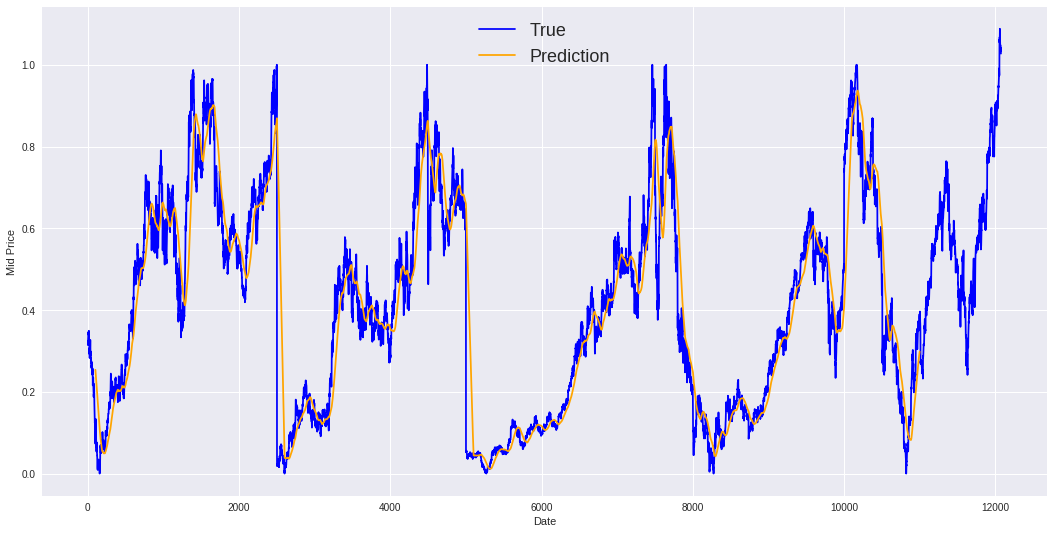

In [0]:

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

## Introduction to LSTM: Making Stock Movement Predictions Far into the Future

Long Short-Term Memory (LSTM) models are extremely powerful time-series models. A LSTM can predict an arbitrary number of steps into the future. A LSTM module (or a cell) has 5 essential components which allows them to model both long-term and short-term data. 
* Cell state ($c_t$) - This represents the internal memory of the cell which stores both short term memory and long-term memories
* Hidden state ($h_t$) - This is output state information calculated w.r.t. current input, previous hidden state and current cell input which we eventually use to predict the future stock market prices. Additionally, the hidden state can decide to only retrive the short or long-term or both types of memory stored in the cell state to make the next prediction.
* Input gate ($i_t$) - Decides how much information from current input flows to the cell state
* Forget gate ($f_t$) - Decides how much information from the current input and the previous cell state flows into the current cell state
5. Output gate ($o_t$) - Decides how much information from the current cell state flows into the hidden state, so that if needed LSTM can only pick the long-term memories or short-term memories and long-term memories

An LSTM cell looks like below.

![alt text](https://github.com/thushv89/datacamp_tutorials/raw/5a108979d2998b58d9e7a011671c1527cd3f00d7/Reviewed/lstm.png)

And the equations for calculating each of these entities are as follows.

* $i_t = \sigma(W_{ix}x_t + W_{ih}h_{t-1}+b_i)$
* $\tilde{c}_t = \sigma(W_{cx}x_t + W_{ch}h_{t-1} + b_c)$
* $f_t = \sigma(W_{fx}x_t + W_{fh}h_{t-1}+b_f)$
* $c_t = f_t c_{t-1} + i_t \tilde{c}_t$
* $o_t = \sigma(W_{ox}x_t + W_{oh}h_{t-1}+b_o)$
* $h_t = o_t tanh(c_t)$


Tensorflow provides a nice sub API (called RNN API) for implementing time series models. we will be using that for our implementations.


### Data Generator for LSTM

we are first going to implement a data generator to train our LSTM. This data generator will have a method called **unroll_batches(...)** which will output a set of *num_unrollings* batches of input data obtained sequentially, where a batch of data is of size *[batch_size, 1]*. Then each batch of input data will have a corresponding output batch of data. 

For example if *num_unrollings=3* and *batch_size=4* a set of unrolled batches it might look like,
* input data: $[x_0,x_10,x_20,x_30], [x_1,x_11,x_21,x_31], [x_2,x_12,x_22,x_32]$
* output data: $[x_1,x_11,x_21,x_31], [x_2,x_12,x_22,x_32], [x_3,x_13,x_23,x_33]$

#### Data Augmentation
Also to make our model robust we will not make the output for $x_t$ always $x_{t+1}$. Rather we will randomly sample an output from the set $x_{t+1},x_{t+2},\ldots,x_{t+N}$ where $N$ is a small window size. Here we are making the following assumption.

* $x_{t+1},x_{t+2},\ldots,x_{t+N}$ will not be very far from each other

That's a reasonable assumption for stock movement prediction.

Below we illustrate how a batch of data is created visually.

![alt text](https://github.com/thushv89/datacamp_tutorials/raw/5a108979d2998b58d9e7a011671c1527cd3f00d7/Reviewed/batch.png)

In [0]:

class DataGeneratorSeq(object):
    
    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):
        
        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
        
        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
                
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]
            
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
            
        return batch_data,batch_labels
    
    def unroll_batches(self):
            
        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):
            
            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels
    
    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))
        


dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)
    



Unrolled index 0
	Inputs:  [0.31437907 0.68251073 0.8827639  0.34908384 0.12648556]

	Output: [0.32384238 0.67637324 0.8365174  0.35061213 0.1262407 ]


Unrolled index 1
	Inputs:  [0.32384238 0.67637324 0.87069887 0.35307965 0.1345414 ]

	Output: [0.33012915 0.67637324 0.8365174  0.35061213 0.12494157]


Unrolled index 2
	Inputs:  [0.32372627 0.6668353  0.8365174  0.35061213 0.1340011 ]

	Output: [0.3396588  0.6731387  0.8405274  0.34492955 0.13545202]


Unrolled index 3
	Inputs:  [0.32695258 0.67637324 0.83310276 0.34492955 0.13545202]

	Output: [0.3460119  0.67637324 0.8405274  0.37608916 0.1262407 ]


Unrolled index 4
	Inputs:  [0.33012915 0.67637324 0.83714783 0.34575522 0.1262407 ]

	Output: [0.33012915 0.6731387  0.8405274  0.34013176 0.12811251]


### Defining Hyperparameters

Here we define several hyperparameters. `D` is the dimensionality of the input. It's straightforward as we take the previous stock price as the input and predict the next, and should be 1. Then we have `num_unrollings`, this is a hyperparameter related to the backpropagation through time (BPTT) that is used to optimize the LSTM model. This denotes how many continuous time steps we consider for a single optimization step. we can think of this as, instead of optimizing the LSTM by looking at a single time step, we optimize the network looking at `num_unrollings` time steps. Larger the better. Then we have the `batch_size`. Batch size is how many data samples we consider in a single time steps. Next we define `num_nodes` which represents the number of hidden neurons in each LSTM cell. we can see that there are three layers of LSTMs in this example.

In [0]:
D = 1 # Dimensionality of the data. Since our data is 1-D this would be 1
num_unrollings = 50 # Number of time steps we look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case we run this multiple times

### Defining Inputs and Outputs

Next we define placeholders for training inputs and labels. This is very straightforward as we have a list of input placeholders, where each placeholder contains a single batch of data. And the list has `num_unrollings` placeholders, that will be used at once for a single optimization step.

In [0]:
# Input data.
train_inputs, train_outputs = [],[]

# we unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))


### Defining Parameters of the LSTM and Regression layer 

we will have a three layers of LSTMs and a linear regression layer (denoted by `w` and `b`), that takes the output of the last LSTM cell and output the prediction for the next time step. we can use the `MultiRNNCell` in TensorFlow to encapsualate the three `LSTMCell` objects we created. Additionally we can have the dropout implemented LSTM cells, as they improve performance and reduce overfitting.

In [0]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

### Calculating LSTM output and Feeding it to the regression layer to get final prediction

In this section, we first create TensorFlow variables (`c` and `h`) that will hold the cell state and the hidden state of the LSTM. Then we transform the list of `train_inputs` to have a shape of `[num_unrollings, batch_size, D]`, this is needed for calculating the outputs with the `tf.nn.dynamic_rnn` function.  we then calculate the lstm outputs with the `tf.nn.dynamic_rnn` function and split the output back to a list of `num_unrolling` tensors. the loss between the predictions and true stock prices.

In [0]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of 
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

### Loss Calculation and Optimizer

Here we calculate the loss. However note that there is a unique characteristic when calculating the loss. For each batch of predictions and true outputs, we calculate the mean squared error. And we sum (not average) all these mean squared losses together. Finally we define the optimizer we're going to use to optimize the LSTM. Here we can use Adam, which is a very recent and well-performing optimizer.

In [0]:
# When calculating the loss we need to be careful about the exact form, because we calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


### Prediction Related Calculations

Here we define the prediction related TensorFlow operations. First define a placeholder for feeding in the input (`sample_inputs`), then similar to the training stage, we define state variables for prediction (`sample_c` and `sample_h`). Finally we calculate the prediction with the `tf.nn.dynamic_rnn` function and then sending the output through the regression layer (`w` and `b`). we also should define the `reset_sample_state` opeartion, that resets the cell state and the hidden state of the LSTM. we should execute this operation at the start, every time we make a sequence of predictions.


In [0]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


### Running the LSTM

Here we will train and predict stock price movements for several epochs and see whether the predictions get better or worse over time. we follow the following procedure.
* Define a test set of starting points (`test_points_seq`) on the time series to evaluate the LSTM at
* For each epoch
 * For full sequence length of training data
   * Unroll a set of `num_unrollings` batches
   * Train the LSTM with the unrolled batches
 * Calculate the average training loss
 * For each starting point in the test set
   * Update the LSTM state by iterating through the previous `num_unrollings` data points found before the test point
   * Make predictions for `n_predict_once` steps continuously, using the previous prediction as the current input
   * Calculate the MSE loss between the `n_predict_once` points predicted and the true stock prices at those time stamps

In [0]:
epochs = 30
valid_summary = 1 # Interval we make test predictions

n_predict_once = 50 # Number of steps we continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings) 

x_axis_seq = []

# Points we start our test predictions from
test_points_seq = np.arange(11000,12000,50).tolist() 

for ep in range(epochs):       
    
    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):
        
        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
        
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l
    
    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))
      
      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))
      
      train_mse_ot.append(average_loss)
            
      average_loss = 0 # reset loss
      
      predictions_seq = []
      
      mse_test_loss_seq = []
      
      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []
        
        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]
        
        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)
        
        feed_dict = {}
        
        current_price = all_mid_data[w_i-1]
        
        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
        
        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)
        
          our_predictions.append(np.asscalar(pred))
        
          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2
        
        session.run(reset_sample_states)
        
        predictions_seq.append(np.array(our_predictions))
        
        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)
        
        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)
        
      current_test_mse = np.mean(mse_test_loss_seq)
      
      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0
      
      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')
      
      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

Initialized
Average loss at step 1: 1.880975
	Test MSE: 0.00311
	Finished Predictions
Average loss at step 2: 0.178781
	Test MSE: 0.00360
	Finished Predictions
Average loss at step 3: 0.109959
	Test MSE: 0.00486
	Finished Predictions
Average loss at step 4: 0.101487
	Decreasing learning rate by 0.5
	Test MSE: 0.00425
	Finished Predictions
Average loss at step 5: 0.082523
	Test MSE: 0.00274
	Finished Predictions
Average loss at step 6: 0.087049
	Test MSE: 0.00295
	Finished Predictions
Average loss at step 7: 0.085453
	Test MSE: 0.00281
	Finished Predictions
Average loss at step 8: 0.083355
	Test MSE: 0.00269
	Finished Predictions
Average loss at step 9: 0.086682
	Test MSE: 0.00245
	Finished Predictions
Average loss at step 10: 0.084317
	Test MSE: 0.00242
	Finished Predictions
Average loss at step 11: 0.083389
	Test MSE: 0.00252
	Finished Predictions
Average loss at step 12: 0.078861
	Test MSE: 0.00269
	Finished Predictions
Average loss at step 13: 0.076794
	Decreasing learning rate by 0

## Visualizing the LSTM Predictions

we can see how the MSE loss is going down with the amount of training. This is good sign that the model is learning something useful. To quantify our findings, we can compare the LSTM's MSE loss to the MSE loss we obtained when doing the standard averaging (0.004). we can see that the LSTM is doing better than the standard averaging. And we know that standard averaging (though not perfect) followed the true stock prices movements reasonably.

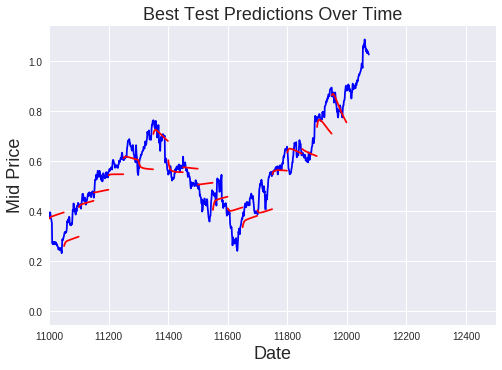

In [0]:
best_prediction_epoch = 28 # replace this with the epoch that we got the best results when running the plotting code

# plt.figure(figsize = (18,18))
# plt.subplot(2,1,1)
# plt.plot(range(df.shape[0]),all_mid_data,color='b')

# # Plotting how the predictions change over time
# # Plot older predictions with low alpha and newer predictions with high alpha
# start_alpha = 0.25
# alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
# for p_i,p in enumerate(predictions_over_time[::3]):
#     for xval,yval in zip(x_axis_seq,p):
#         plt.plot(xval,yval,color='r',alpha=alpha[p_i])

# plt.title('Evolution of Test Predictions Over Time',fontsize=18)
# plt.xlabel('Date',fontsize=18)
# plt.ylabel('Mid Price',fontsize=18)
# plt.xlim(11000,12500)

# plt.subplot(2,1,2)

# Predicting the best test prediction we got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')
    
plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)
plt.show()

Though not perfect, LSTM seems to be able to predict stock price behavior correctly most of the time. Note that we are making predictions roughly in the range of 0 and 1.0 (that is, not the true stock prices). This is okay, because we're predicting the stock price movement, not the prices themselves.